In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"philipdannie","key":"1d64f57c906c1a313a420842df6d7707"}'}

In [ ]:
!pip install -q kaggle


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection


100% 4.00G/4.00G [00:43<00:00, 174MB/s]
100% 4.00G/4.00G [00:43<00:00, 98.6MB/s]


 # here we are unzipping the folder, to read the folder for the training purpose..using !unzip /path link

In [ ]:
!ls 

sample_data


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

Importing the necessary packages 

In [ ]:
import glob 
import os
import random
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16,mobilenet_v3
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models,optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input 
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet50
import keras
import numpy as np

Here we are extracting the training data from the folder of distracted driver.

In [ ]:
# path = "/kaggle/input/state-farm-distracted-driver-detection/imgs/"
path = "/content/imgs/"
train_dir = path + "train/"
valid_dir = path + "val/"
test_dir  = path + 'test/' # so here we are tr

Checking out the number of classes presented in train data images,
where, 
c0 - safe drivers.
c1............c9 classes are unsafe driving were drivers doing unsafe things while driving.

In [ ]:
classes = [c for c in os.listdir(train_dir)]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


Here we are doing shaping all the images into 20 - 20 standard formate.for different classes.

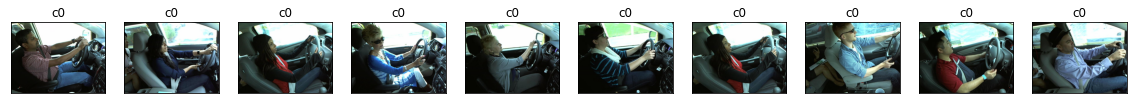

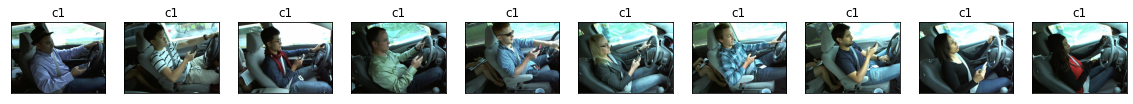

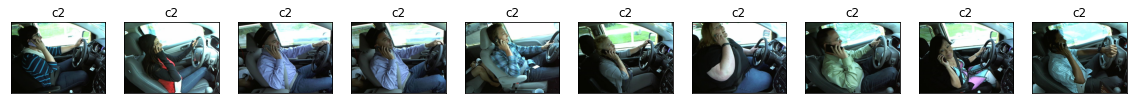

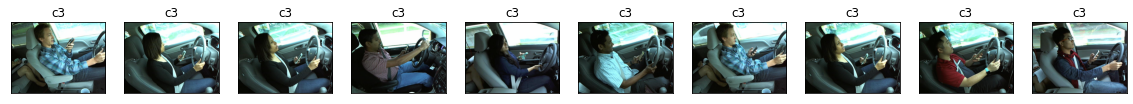

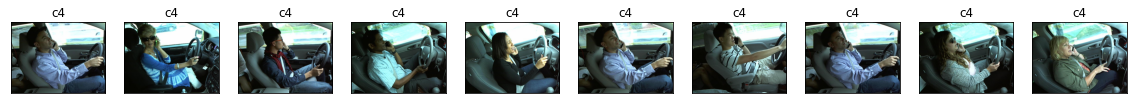

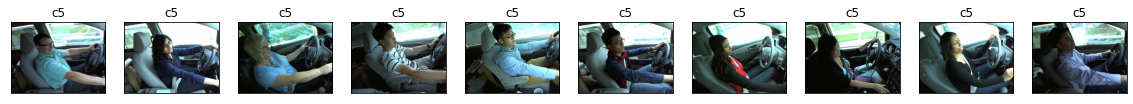

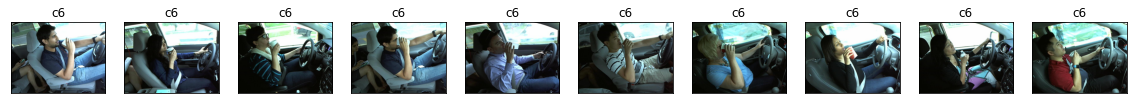

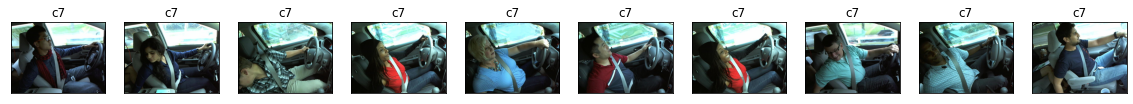

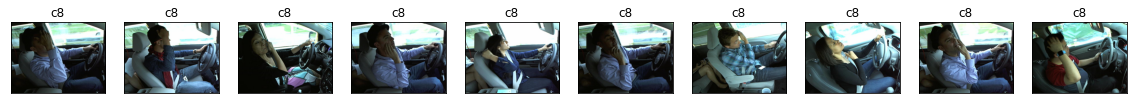

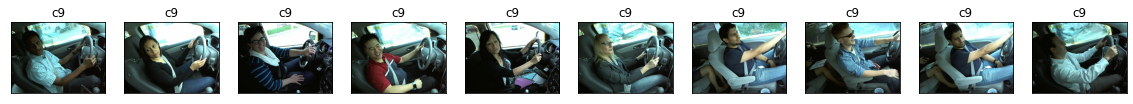

In [ ]:
classes.sort()
for c in classes:

    fig=plt.figure(figsize=(20,20))
    cl = train_dir + c
    for i,sample in enumerate(random.sample(os.listdir(train_dir + c) , 10)):
        fig.add_subplot(10, 10, i+1)
        image = plt.imread(cl + '/' + sample)

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{c}")

Mapping the classes for to make excel sheet at the end of the project.

In [ ]:
classes_mapping = {   'c0' : "safe_driving",
                      'c1' : "texting-right",
                      'c2' : "talking_on_the_phone-right",
                      'c3' : "texting-left",
                      'c4' : "talking_on_the_phone-left",
                      'c5' : "operating_the_radio",
                      'c6' : "drinking",
                      'c7' : "reaching_behind",
                      'c8' : "hair-and-makeup",
                      'c9' : "talking_to_passenger"}

In [ ]:
for c in os.listdir(train_dir):
    shutil.move(os.path.join(train_dir,c), os.path.join(train_dir,classes_mapping[f'{c}']))

here we can see that different lenghts for validation , test and train data.

In [ ]:
for c in os.listdir(train_dir):
    os.makedirs(valid_dir + '/' + c, exist_ok=True)
    os.makedirs(test_dir + '/' + c, exist_ok=True)
    
    c_train_dir = train_dir + c
    c_len = len([sample for sample in os.listdir(c_train_dir)])
    print(c_len)
    
    for sample in random.sample(os.listdir(c_train_dir) , int(float(0.1) * c_len)):
        shutil.move(c_train_dir + '/' + sample, valid_dir + c)
        
    for sample in random.sample(os.listdir(c_train_dir) , int(float(0.1) * c_len)):
        shutil.move(c_train_dir + '/' + sample, test_dir + c)

2002
1911
2312
2346
2317
2129
2267
2325
2326
2489


we are doing data for augmentation to overcome the overfitting

In [ ]:
train_datagen_augmentation = ImageDataGenerator(rescale=1 / 255.0,
                                                zoom_range=0.05,
                                                width_shift_range=0.05,
                                                height_shift_range=0.05,
                                                shear_range=0.05,
                                                fill_mode="nearest")


test_datagen = ImageDataGenerator(rescale=1 / 255.0)

without augmentation.

In [ ]:


batch_size = 32
train_batches = test_datagen.flow_from_directory(directory = train_dir,shuffle = True, 
                                                   batch_size = batch_size)

val_batches = test_datagen.flow_from_directory(directory = valid_dir,shuffle = True, 
                                                   batch_size = batch_size)

test_batches = test_datagen.flow_from_directory(directory= test_dir,shuffle = False, 
                                                   batch_size = 1)

Found 17950 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


In [ ]:
train_batches.class_indices

{'drinking': 0,
 'hair-and-makeup': 1,
 'operating_the_radio': 2,
 'reaching_behind': 3,
 'safe_driving': 4,
 'talking_on_the_phone-left': 5,
 'talking_on_the_phone-right': 6,
 'talking_to_passenger': 7,
 'texting-left': 8,
 'texting-right': 9}

In [ ]:
len(train_batches.labels)

17950

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Flatten(input_shape=(256,256,3)))
base_model.add(layers.Dense(1024,activation = 'relu',name = 'input'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(1024,activation = 'relu',name = 'l1'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(512,activation = 'relu',name = 'l2'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(512,activation = 'relu',name = 'l3'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(256,activation = 'relu',name = 'l4'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(256,activation = 'relu',name = 'l5'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(128,activation = 'relu' ,name ='l6'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(128,activation = 'relu' ,name ='l7'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(32,activation = 'relu' ,name ='l8'))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Dense(10,activation = 'softmax',name = 'output'))


In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 input (Dense)               (None, 1024)              201327616 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 l1 (Dense)                  (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 l2 (Dense)                  (None, 512)               5

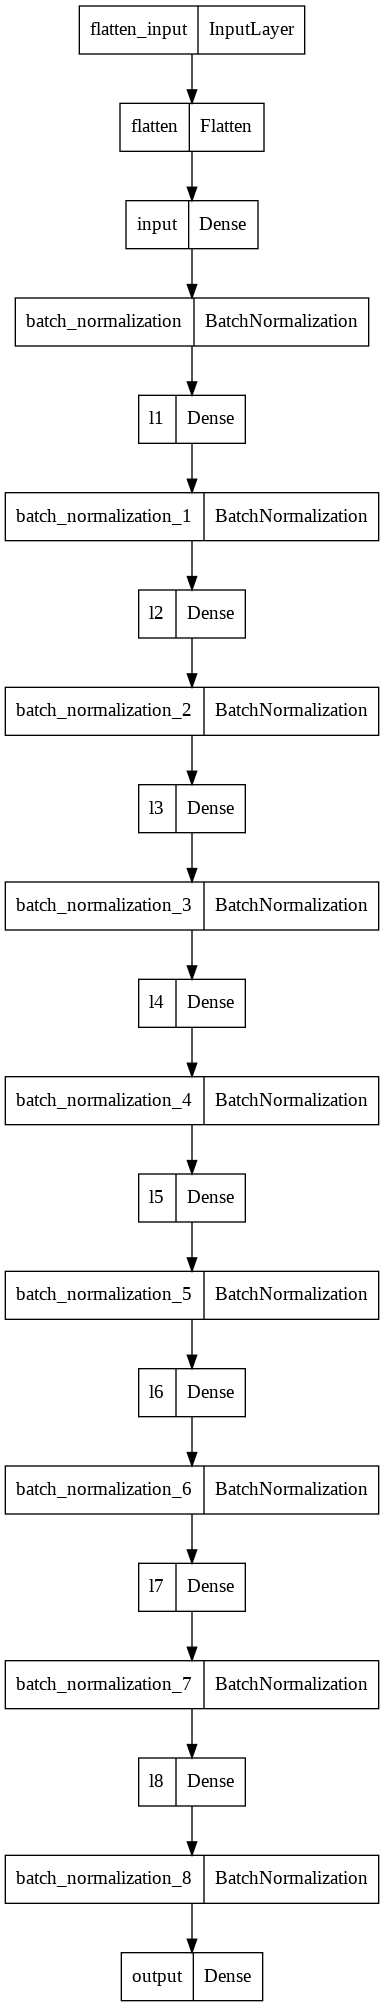

In [ ]:
plot_model(base_model)

In [ ]:
base_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
history = base_model.fit(x = train_batches,
          steps_per_epoch=350,
          epochs=15,
          validation_data = val_batches,
          validation_steps= 50,
          callbacks=[es])

Epoch 1/15
350/350 [==============================] - 478s 1s/step - loss: 2.0103 - accuracy: 0.2842 - val_loss: 2.7492 - val_accuracy: 0.1994
Epoch 2/15
350/350 [==============================] - 473s 1s/step - loss: 1.1151 - accuracy: 0.6081 - val_loss: 1.7050 - val_accuracy: 0.5288
Epoch 3/15
350/350 [==============================] - 474s 1s/step - loss: 0.6005 - accuracy: 0.8031 - val_loss: 0.5916 - val_accuracy: 0.8100
Epoch 4/15
350/350 [==============================] - 473s 1s/step - loss: 0.3916 - accuracy: 0.8759 - val_loss: 0.5047 - val_accuracy: 0.8400
Epoch 5/15
350/350 [==============================] - 480s 1s/step - loss: 0.2923 - accuracy: 0.9094 - val_loss: 0.6208 - val_accuracy: 0.8181
Epoch 6/15
350/350 [==============================] - 477s 1s/step - loss: 0.2316 - accuracy: 0.9285 - val_loss: 0.7702 - val_accuracy: 0.7869
Epoch 7/15
350/350 [==============================] - 475s 1s/step - loss: 0.1882 - accuracy: 0.9441 - val_loss: 0.2647 - val_accuracy: 0.9200

In [ ]:
test_loss, test_acc = base_model.evaluate(test_batches)
print(test_loss, test_acc)

2237/2237 [==============================] - 187s 83ms/step - loss: 0.5919 - accuracy: 0.8203
0.5918595194816589 0.8202950358390808


In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_input',input_shape = (256,256,3)))
cnn_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_2',padding = 'same'))
cnn_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_3',padding = 'same'))

cnn_model.add(layers.BatchNormalization())


cnn_model.add(layers.MaxPooling2D((2,2),name = 'max_1'))
cnn_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_4',padding='same'))
cnn_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_5',padding='same'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D((2,2),name = 'max_2'))

cnn_model.add(layers.Conv2D(128,(3,3),activation='relu'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(128,(3,3),activation='relu'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512,activation = 'relu',name = 'D1',))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(256,activation = 'relu',name = 'D2'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(256,activation = 'relu',name = 'D3'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(128,activation = 'relu' ,name ='D4'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(10,activation = 'softmax',name = 'output'))

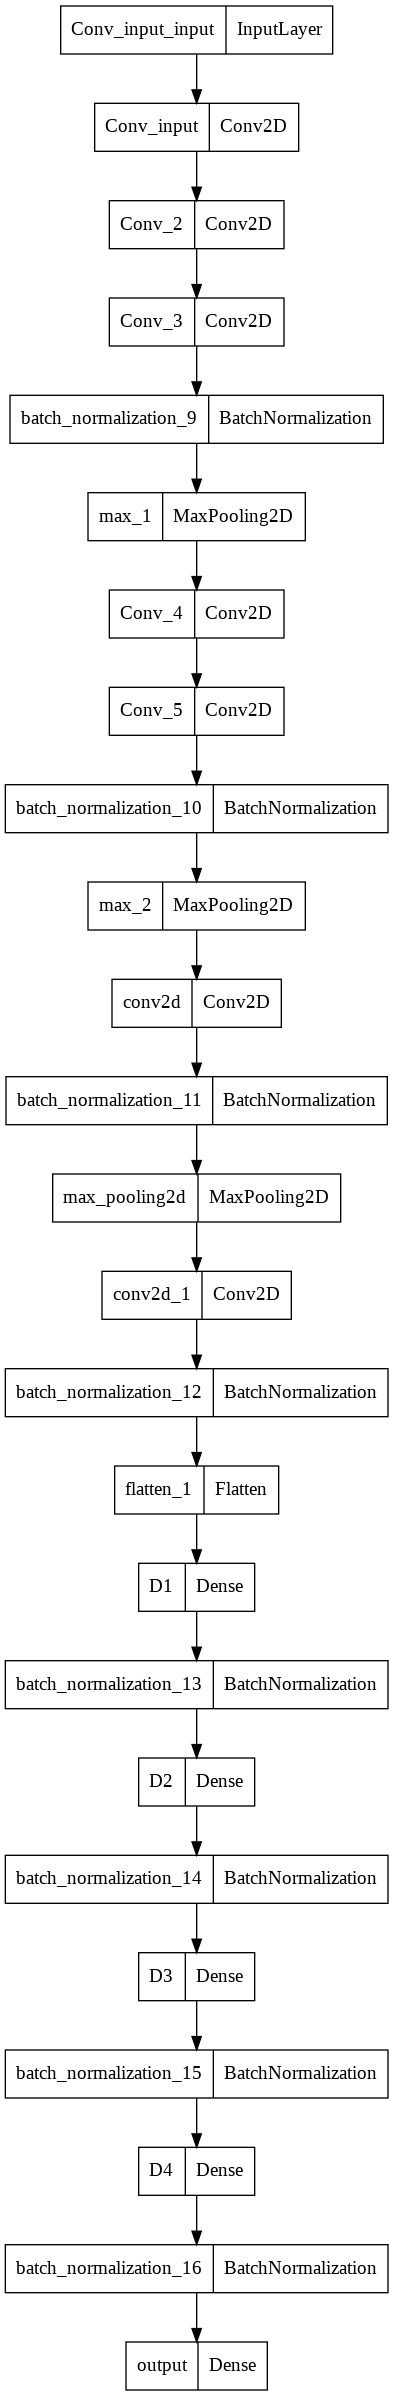

In [ ]:
plot_model(cnn_model)

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_input (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 Conv_2 (Conv2D)             (None, 254, 254, 32)      9248      
                                                                 
 Conv_3 (Conv2D)             (None, 254, 254, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_1 (MaxPooling2D)        (None, 127, 127, 32)      0         
                                                                 
 Conv_4 (Conv2D)             (None, 127, 127, 64)      18496     
                                                      

In [ ]:
from tensorflow.keras.optimizers import RMSprop

cnn_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3,)

history = cnn_model.fit(x = train_batches,
          steps_per_epoch=15,
          epochs=15,
          validation_data = val_batches,
          validation_steps= 50,
          callbacks=[es])

NameError: ignored